# Lab 4: Experimentación de arquitecturas CNN

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de validación superior al **90%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc. Se deben de realizar como **mínimo *8* experimentos.** Siendo de libre elección.
*  En caso de llegar antes del experimento 8 al **90 %** hay que seguir investigando hasta llegar a los 8 experimentos.
* Si hemos llegado al experimento 8 y no hemos conseguido llegar al **90 %** no hay problema en seguir realizando experimentos hasta llegar al desempeño objetivo.
*  El desempeño a tener en cuenta es el val acurracy, hay que añadir una primera fila con el mejor valor del laboratorio anterior.
*   Análisis  de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo? De 100 imagenes aleatorias del dataset de testing con el valor inferido. Compare un análisis visual con  una matriz de confusión.


Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

## Carga de los datos

In [1]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import glob


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

523789527/523789527 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step
10658925/10658925 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [3]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [4]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [5]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

x_train, y_train = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
x_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [6]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(x_train))
x_train, y_train = x_train[perm], y_train[perm]

In [7]:
# Definición de funciones que permitirán la visualización de las graficas de entrenamiento
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
    plt.show()

def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
    plt.show()

def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento ' + name1, 'Validación ' + name1,
                'Entrenamiento ' + name2, 'Validación ' + name2],
               loc='upper right')
    plt.show()

def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1,
                'Train ' + name2, 'Val ' + name2],
               loc='lower right')
    plt.show()



In [8]:
val_acc_lab3=0.72914
val_loss_lab3= 2.27094

from prettytable import PrettyTable

myTable = PrettyTable(["Experimento", "Accuracy", "Loss"])

# Add rows
myTable.add_row(["0", "{0:.5f}".format(val_acc_lab3), "{0:.5f}".format(val_loss_lab3)])
print(myTable)

+-------------+----------+---------+
| Experimento | Accuracy |   Loss  |
+-------------+----------+---------+
|      0      | 0.72914  | 2.27094 |
+-------------+----------+---------+


## Realización de los experimentos

Primeramente vamos a visualizar aleatoriamente algunas imagenes del dataset de training junto con su etiqueta.

In [9]:
# Asociación de valor etiqueta con su la descripción de la prenda
nombre_personajes = ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum',
                     'comic_book_guy', 'edna_krabappel', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lisa_simpson',
                     'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'principal_skinner',
                     'sideshow_bob']
print (nombre_personajes)

['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']


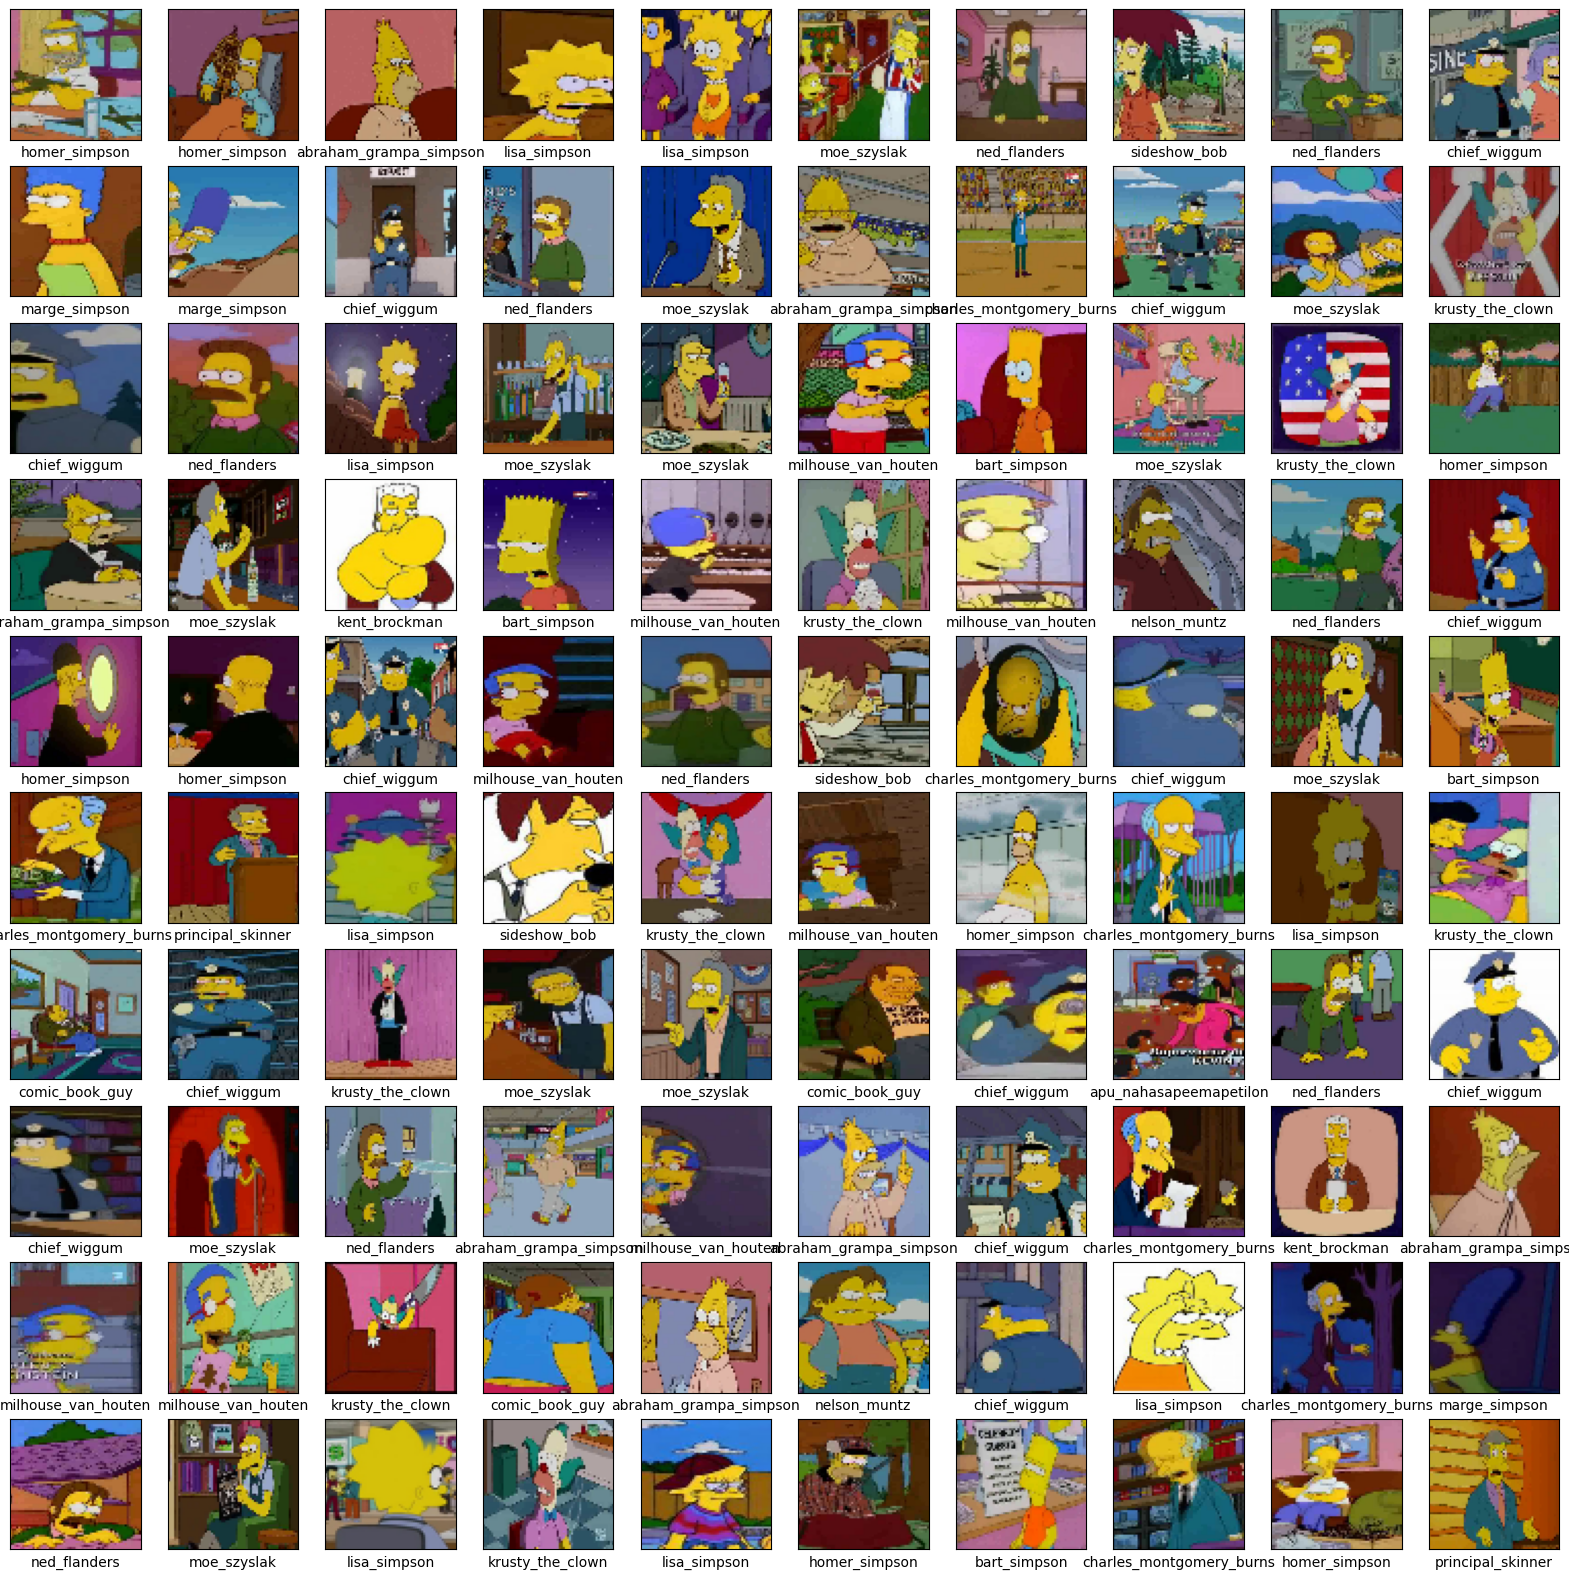

In [10]:
from random import sample
lista = range(0,len(x_train))
lista_aleatoria=sample(lista,k=100)
j=0


# Ajustamos el tamaño de imagen
plt.figure(figsize=(20,20))
# Seleccionamos las 100 primeras imagenes
for i in lista_aleatoria:
    # Las visulizamos en 10 filas y 10 columnas
    plt.subplot(10,10,j+1)
    j=j+1
    plt.xticks([])
    plt.yticks([])
    # Omitimos el grid
    plt.grid(False)
    # Conversión de la imagen de BGR a RGB
    img = cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    # Añadimos a cada imagen su etiqueta
    plt.xlabel(nombre_personajes[y_train[i]])

# Finalmente visualizamos
plt.show()

In [11]:
# Commprobamos el número de imagenes junto con su formato
x_train.shape

(18992, 64, 64, 3)

In [12]:
# Normalizacion
x_train = x_train / 255.0
x_test = x_test / 255.0

### Experimento 1

In [13]:
from keras import layers
from keras import models
from keras.optimizers import Adamax, RMSprop, SGD
from keras.callbacks import EarlyStopping


# Definir y construir modelo
model = models.Sequential()
model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-1'))
model.add(layers.Dense(64, activation='relu', name='Hidden-Layer-2'))
model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))
model.summary()

# Compilar modelo
model.compile(
                      optimizer=SGD(),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
)
# Log del entrenamiento se guarda para analisis y visualizacion

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

model_1_Relu = model.fit(
                      x_train,
                      y_train,
                      epochs = 30,
                      batch_size= 32,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks = [early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Convolutiva-1 (Conv2D)               │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-1 (MaxPooling2D)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 18)                  │           1,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,398,994 (32.04 MB)

 Trainable params: 8,398,994 (32.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.1398 - loss: 2.7309 - val_accuracy: 0.2656 - val_loss: 2.3684
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3139 - loss: 2.2801 - val_accuracy: 0.3517 - val_loss: 2.1211
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4121 - loss: 1.9661 - val_accuracy: 0.4606 - val_loss: 1.8671
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4922 - loss: 1.7293 - val_accuracy: 0.5049 - val_loss: 1.6572
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5546 - loss: 1.5363 - val_accuracy: 0.5193 - val_loss: 1.5762
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5955 - loss: 1.3734 - val_accuracy: 0.5696 - val_loss: 1.4461
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6483 - loss: 1.2025 - val_accuracy: 0.5949 - val_loss: 1.3648
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6942 - loss: 1.0650 - val_accuracy: 0

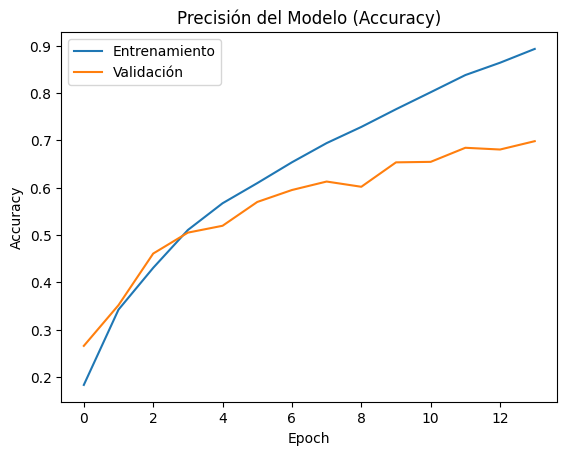

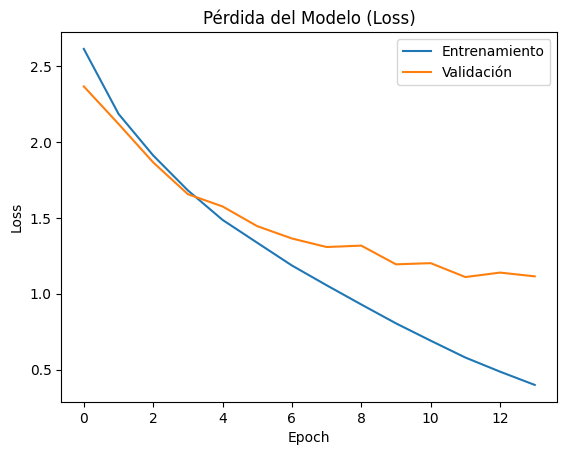

In [16]:
import matplotlib.pyplot as plt

# Graficar la precisión (accuracy)
plot_acc(model_1_Relu, title="Precisión del Modelo (Accuracy)")

# Graficar la pérdida (loss)
plot_loss(model_1_Relu, title="Pérdida del Modelo (Loss)")

In [67]:
# Definir valores de accuracy y loss del modelo
acc_model_1 = model_1_Relu.history['val_accuracy'][-1]
loss_model_1 = model_1_Relu.history['val_loss'][-1]

# Crear una instancia de PrettyTable
myTable = PrettyTable(["Experimento", "Val Accuracy", "Val Loss"])

# Agregar la fila con los resultados del modelo
myTable.add_row(["Modelo 1 (ReLU)", "{:.5f}".format(acc_model_1), "{:.5f}".format(loss_model_1)])

# Imprimir la tabla
print(myTable)

+-----------------+--------------+----------+
|   Experimento   | Val Accuracy | Val Loss |
+-----------------+--------------+----------+
| Modelo 1 (ReLU) |   0.69808    | 1.11499  |
+-----------------+--------------+----------+


#### Conclusión

In [ ]:
# Para este primer experimento se ha usao al modelo con mejor accurcy del Lab 3.
# Se ha conseguido un 69% de Val Accuracy, todavia lejos del 90% objetivo.
# En los proximos experimentos se debera ajustar ciertos parametros para conseguirlo.
# Dado solo ha completado la mitad de las epocas se va a proceder a aumentar la 'patience'.
# En caso de que no mejore el 'overfitting' aumentando la patience se modificara el learning rate del modelo.

### Experimento 2

In [17]:
from keras import layers
from keras import models
from keras.optimizers import Adamax, RMSprop, SGD
from keras.callbacks import EarlyStopping


# Definir y construir modelo
model = models.Sequential()
model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-1'))
model.add(layers.Dense(64, activation='relu', name='Hidden-Layer-2'))
model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))
model.summary()

# Compilar modelo
model.compile(
                      optimizer=SGD(),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
)
# Log del entrenamiento se guarda para analisis y visualizacion

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

model_2_Relu_patience = model.fit(
                      x_train,
                      y_train,
                      epochs = 30,
                      batch_size= 32,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks = [early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Convolutiva-1 (Conv2D)               │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-1 (MaxPooling2D)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 18)                  │           1,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,398,994 (32.04 MB)

 Trainable params: 8,398,994 (32.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1530 - loss: 2.7187 - val_accuracy: 0.2601 - val_loss: 2.3775
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3203 - loss: 2.2542 - val_accuracy: 0.3675 - val_loss: 2.0985
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4163 - loss: 1.9608 - val_accuracy: 0.4575 - val_loss: 1.8582
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4827 - loss: 1.7584 - val_accuracy: 0.5038 - val_loss: 1.6917
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5459 - loss: 1.5499 - val_accuracy: 0.5338 - val_loss: 1.5784
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5930 - loss: 1.3862 - val_accuracy: 0.5615 - val_loss: 1.4805
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6392 - loss: 1.2443 - val_accuracy: 0.5738 - val_loss: 1.4083
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6796 - loss: 1.0971 - val_accuracy: 0

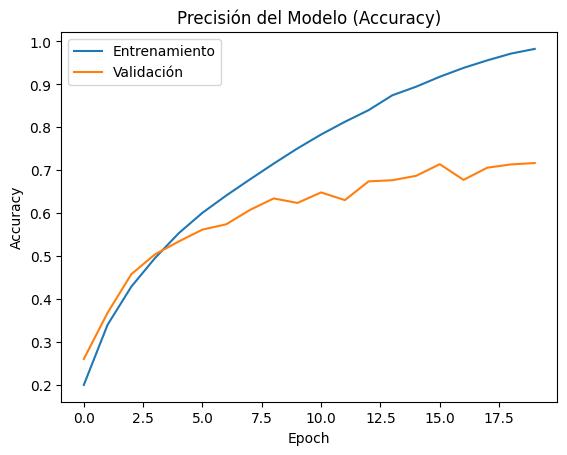

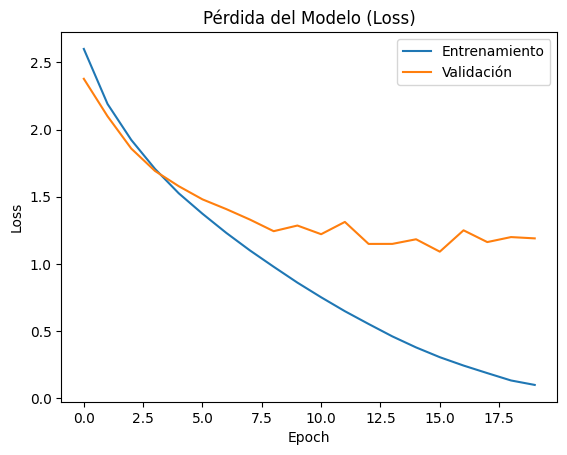

In [18]:
# Graficar la precisión (accuracy)
plot_acc(model_2_Relu_patience, title="Precisión del Modelo (Accuracy)")

# Graficar la pérdida (loss)
plot_loss(model_2_Relu_patience, title="Pérdida del Modelo (Loss)")

In [68]:
# Definir valores de accuracy y loss del modelo
acc_model_2 = model_2_Relu_patience.history['val_accuracy'][-1]
loss_model_2 = model_2_Relu_patience.history['val_loss'][-1]

# Agregar la fila con los resultados del modelo
myTable.add_row(["Modelo 2 (ReLU)", "{:.5f}".format(acc_model_2), "{:.5f}".format(loss_model_2)])

# Imprimir la tabla
print(myTable)

+-----------------+--------------+----------+
|   Experimento   | Val Accuracy | Val Loss |
+-----------------+--------------+----------+
| Modelo 1 (ReLU) |   0.69808    | 1.11499  |
| Modelo 2 (ReLU) |   0.71650    | 1.19031  |
+-----------------+--------------+----------+


#### Conclusión

In [ ]:
# La mejora ha sido escasa y no se ha solucionado el overfitting.
# Se va a proceder a añadir mas capas para mejorar el analisis de las imagenes.
# En cuanto al overfitting se va a ajustar un learning rate mas bajo para evitarlo.

### Experimento 3

In [23]:
from keras import layers
from keras import models
from keras.optimizers import Adamax, RMSprop, SGD
from keras.callbacks import EarlyStopping


# Definir y construir modelo
model = models.Sequential()
model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(layers.Conv2D(64,(2,2), activation='relu', padding='same', name='Convolutiva-2'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-2'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', name='Hidden-Layer-1'))
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-2'))
model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))
model.summary()

# Compilar modelo
model.compile(
                      optimizer=SGD(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
)
# Log del entrenamiento se guarda para analisis y visualizacion

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

model_3_Relu_capa_lr = model.fit(
                      x_train,
                      y_train,
                      epochs = 30,
                      batch_size= 32,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks = [early_stopping]
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Convolutiva-1 (Conv2D)               │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-1 (MaxPooling2D)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolutiva-2 (Conv2D)               │ (None, 32, 32, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-2 (MaxPooling2D)          │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,247,058 (16.20 MB)

 Trainable params: 4,247,058 (16.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.0321 - loss: 2.9033 - val_accuracy: 0.0400 - val_loss: 2.8874
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.0449 - loss: 2.8864 - val_accuracy: 0.0821 - val_loss: 2.8759
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0859 - loss: 2.8750 - val_accuracy: 0.0890 - val_loss: 2.8667
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0854 - loss: 2.8658 - val_accuracy: 0.0866 - val_loss: 2.8582
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0871 - loss: 2.8603 - val_accuracy: 0.0953 - val_loss: 2.8507
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0955 - loss: 2.8521 - val_accuracy: 0.1011 - val_loss: 2.8440
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1031 - loss: 2.8464 - val_accuracy: 0.1129 - val_loss: 2.8376
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1135 - loss: 2.8394 - val_accuracy: 0

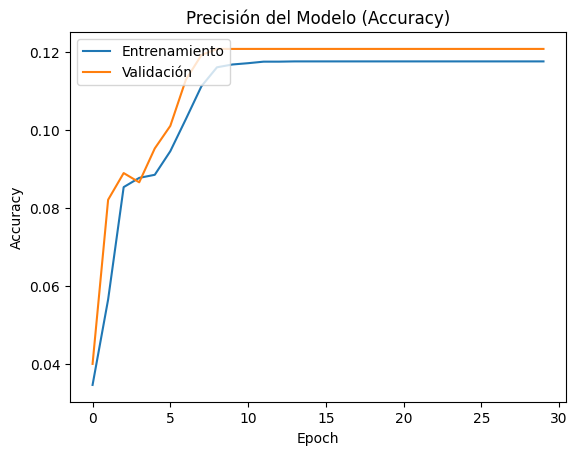

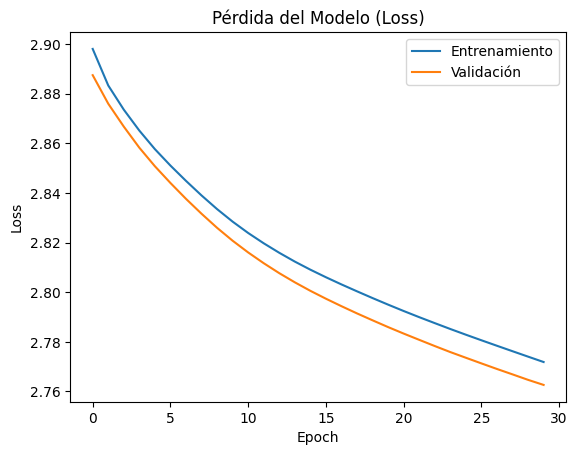

In [24]:
# Graficar la precisión (accuracy)
plot_acc(model_3_Relu_capa_lr, title="Precisión del Modelo (Accuracy)")

# Graficar la pérdida (loss)
plot_loss(model_3_Relu_capa_lr, title="Pérdida del Modelo (Loss)")

In [69]:
# Definir valores de accuracy y loss del modelo
acc_model_3 = model_3_Relu_capa_lr.history['val_accuracy'][-1]
loss_model_3 = model_3_Relu_capa_lr.history['val_loss'][-1]

# Agregar la fila con los resultados del modelo
myTable.add_row(["Modelo 3 (ReLU)", "{:.5f}".format(acc_model_3), "{:.5f}".format(loss_model_3)])

# Imprimir la tabla
print(myTable)

+-----------------+--------------+----------+
|   Experimento   | Val Accuracy | Val Loss |
+-----------------+--------------+----------+
| Modelo 1 (ReLU) |   0.69808    | 1.11499  |
| Modelo 2 (ReLU) |   0.71650    | 1.19031  |
| Modelo 3 (ReLU) |   0.12082    | 2.76263  |
+-----------------+--------------+----------+


#### Conclusión

In [ ]:
# Se ha solucionado el overfitting pero los resultados son pesimos.
# El learning rate es demasiado bajo y converge muy lento, hay que aumentarlo.

### Experimento 4

In [30]:
# Definir y construir modelo
model = models.Sequential()
model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(layers.Conv2D(64,(2,2), activation='relu', padding='same', name='Convolutiva-2'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-2'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', name='Hidden-Layer-1'))
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-2'))
model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))
model.summary()

# Compilar modelo
model.compile(
                      optimizer=SGD(learning_rate=0.002),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
)
# Log del entrenamiento se guarda para analisis y visualizacion

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

model_4_Relu_lr = model.fit(
                      x_train,
                      y_train,
                      epochs = 30,
                      batch_size= 32,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks = [early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Convolutiva-1 (Conv2D)               │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-1 (MaxPooling2D)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolutiva-2 (Conv2D)               │ (None, 32, 32, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-2 (MaxPooling2D)          │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,247,058 (16.20 MB)

 Trainable params: 4,247,058 (16.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1168 - loss: 2.8313 - val_accuracy: 0.1211 - val_loss: 2.7641
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1174 - loss: 2.7573 - val_accuracy: 0.1356 - val_loss: 2.7103
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1438 - loss: 2.6969 - val_accuracy: 0.1682 - val_loss: 2.6242
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2079 - loss: 2.5806 - val_accuracy: 0.2598 - val_loss: 2.4682
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2729 - loss: 2.4185 - val_accuracy: 0.2998 - val_loss: 2.3195
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3219 - loss: 2.2585 - val_accuracy: 0.3211 - val_loss: 2.2140
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3599 - loss: 2.1599 - val_accuracy: 0.3477 - val_loss: 2.1488
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3850 - loss: 2.0773 - val_accuracy: 

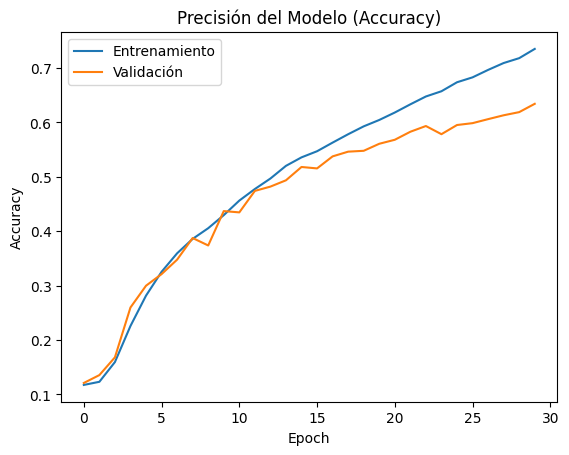

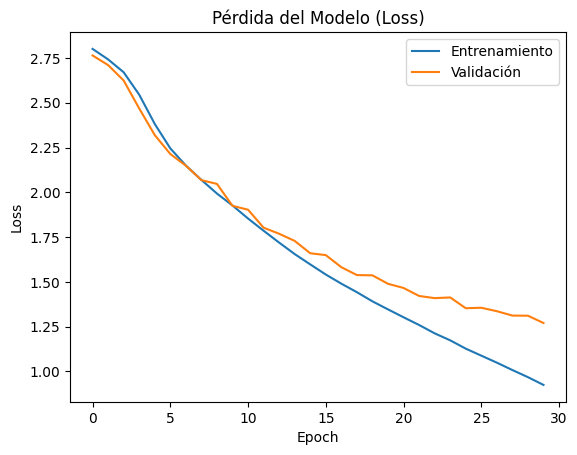

In [31]:
# Graficar la precisión (accuracy)
plot_acc(model_4_Relu_lr, title="Precisión del Modelo (Accuracy)")

# Graficar la pérdida (loss)
plot_loss(model_4_Relu_lr, title="Pérdida del Modelo (Loss)")

In [70]:
# Definir valores de accuracy y loss del modelo
acc_model_4 = model_4_Relu_lr.history['val_accuracy'][-1]
loss_model_4 = model_4_Relu_lr.history['val_loss'][-1]

# Agregar la fila con los resultados del modelo
myTable.add_row(["Modelo 4 (ReLU)", "{:.5f}".format(acc_model_4), "{:.5f}".format(loss_model_4)])

# Imprimir la tabla
print(myTable)

+-----------------+--------------+----------+
|   Experimento   | Val Accuracy | Val Loss |
+-----------------+--------------+----------+
| Modelo 1 (ReLU) |   0.69808    | 1.11499  |
| Modelo 2 (ReLU) |   0.71650    | 1.19031  |
| Modelo 3 (ReLU) |   0.12082    | 2.76263  |
| Modelo 4 (ReLU) |   0.63411    | 1.27055  |
+-----------------+--------------+----------+


#### Conclusión

In [ ]:
# No se han mejorado los resultados del experimento 1.
# Se va a cambiar SGD por Adam que coverge mas rapido.

### Experimento 5

In [37]:
from keras.optimizers import Adam

# Definir y construir modelo
model = models.Sequential()
model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(layers.Conv2D(64,(2,2), activation='relu', padding='same', name='Convolutiva-2'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-2'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', name='Hidden-Layer-1'))
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-2'))
model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))
model.summary()

# Compilar modelo
model.compile(
                      optimizer = Adam(learning_rate=0.0002),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
)
# Log del entrenamiento se guarda para analisis y visualizacion

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

model_5_Relu_adam = model.fit(
                      x_train,
                      y_train,
                      epochs = 30,
                      batch_size= 32,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks = [early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Convolutiva-1 (Conv2D)               │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-1 (MaxPooling2D)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolutiva-2 (Conv2D)               │ (None, 32, 32, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-2 (MaxPooling2D)          │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,247,058 (16.20 MB)

 Trainable params: 4,247,058 (16.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.2288 - loss: 2.5015 - val_accuracy: 0.4964 - val_loss: 1.7086
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5558 - loss: 1.5301 - val_accuracy: 0.5641 - val_loss: 1.4580
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6356 - loss: 1.2518 - val_accuracy: 0.6238 - val_loss: 1.2771
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6903 - loss: 1.0546 - val_accuracy: 0.6386 - val_loss: 1.2049
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7378 - loss: 0.8958 - val_accuracy: 0.6754 - val_loss: 1.1100
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7849 - loss: 0.7483 - val_accuracy: 0.6754 - val_loss: 1.1039
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8242 - loss: 0.6315 - val_accuracy: 0.7015 - val_loss: 1.0426
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8550 - loss: 0.5120 - val_accuracy:

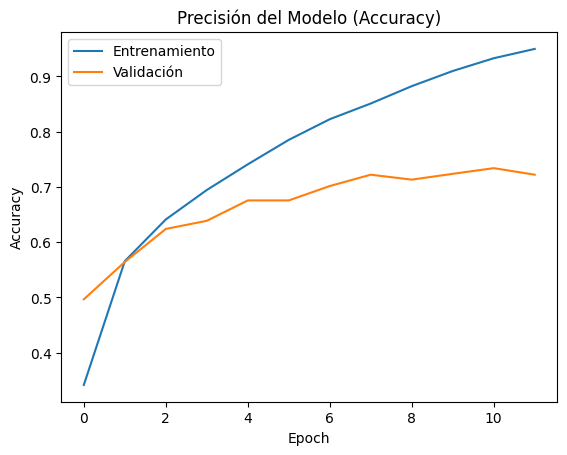

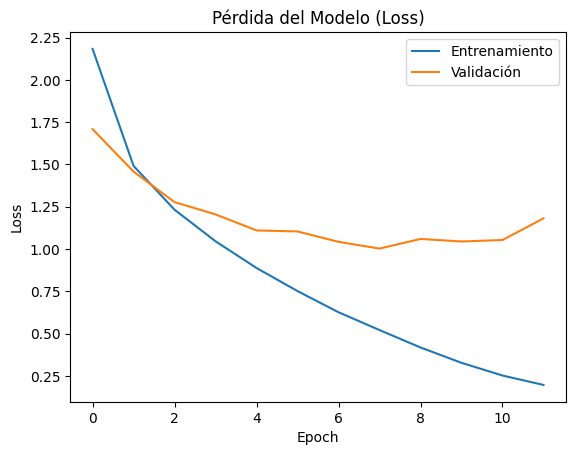

In [38]:
# Graficar la precisión (accuracy)
plot_acc(model_5_Relu_adam, title="Precisión del Modelo (Accuracy)")

# Graficar la pérdida (loss)
plot_loss(model_5_Relu_adam, title="Pérdida del Modelo (Loss)")

In [71]:
# Definir valores de accuracy y loss del modelo
acc_model_5 = model_5_Relu_adam.history['val_accuracy'][-1]
loss_model_5 = model_5_Relu_adam.history['val_loss'][-1]

# Agregar la fila con los resultados del modelo
myTable.add_row(["Modelo 5 (ReLU)", "{:.5f}".format(acc_model_5), "{:.5f}".format(loss_model_5)])

# Imprimir la tabla
print(myTable)

+-----------------+--------------+----------+
|   Experimento   | Val Accuracy | Val Loss |
+-----------------+--------------+----------+
| Modelo 1 (ReLU) |   0.69808    | 1.11499  |
| Modelo 2 (ReLU) |   0.71650    | 1.19031  |
| Modelo 3 (ReLU) |   0.12082    | 2.76263  |
| Modelo 4 (ReLU) |   0.63411    | 1.27055  |
| Modelo 5 (ReLU) |   0.72203    | 1.18113  |
+-----------------+--------------+----------+


#### Conclusión

In [ ]:
# Se han conseguido mejorar los resultados pero aun asi no es suficiente.
# Ha vuelto a tener overfitting.
# Se va a probar a aumentar el batch_size con menos patience y mayor learning_rate
# para hacer una prueba rapida y ver si mejora el resultado anterior.

### Experimento 6

In [40]:
# Definir y construir modelo
model = models.Sequential()
model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(layers.Conv2D(64,(2,2), activation='relu', padding='same', name='Convolutiva-2'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-2'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', name='Hidden-Layer-1'))
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-2'))
model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))
model.summary()

# Compilar modelo
model.compile(
                      optimizer = Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
)
# Log del entrenamiento se guarda para analisis y visualizacion

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

model_6_Relu_ba_pa_lr = model.fit(
                      x_train,
                      y_train,
                      epochs = 30,
                      batch_size= 64,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks = [early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Convolutiva-1 (Conv2D)               │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-1 (MaxPooling2D)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolutiva-2 (Conv2D)               │ (None, 32, 32, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-2 (MaxPooling2D)          │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,247,058 (16.20 MB)

 Trainable params: 4,247,058 (16.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.2810 - loss: 2.3523 - val_accuracy: 0.5594 - val_loss: 1.4741
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6260 - loss: 1.2694 - val_accuracy: 0.6623 - val_loss: 1.1454
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7509 - loss: 0.8398 - val_accuracy: 0.7149 - val_loss: 0.9922
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8568 - loss: 0.5089 - val_accuracy: 0.7299 - val_loss: 0.9667
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9185 - loss: 0.2915 - val_accuracy: 0.7468 - val_loss: 0.9998
Epoch 6/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9566 - loss: 0.1606 - val_accuracy: 0.7581 - val_loss: 1.0997
Epoch 7/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9785 - loss: 0.0900 - val_accuracy: 0.7539 - val_loss: 1.1303
Epoch 7: early stopping


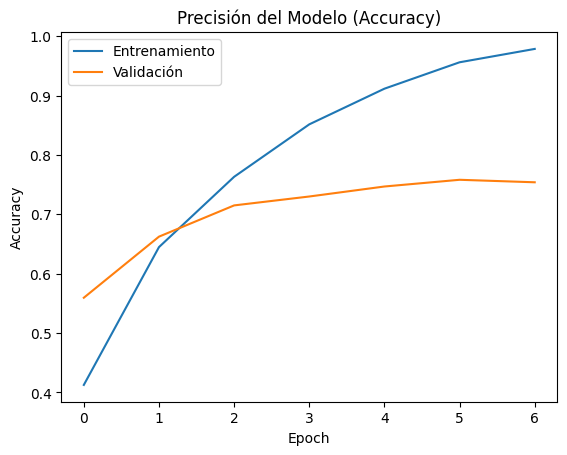

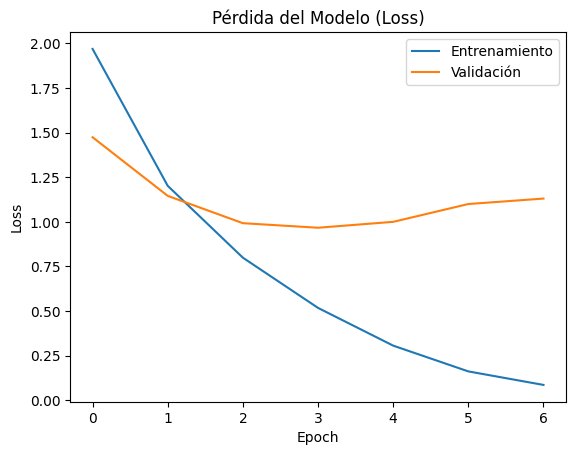

In [41]:
# Graficar la precisión (accuracy)
plot_acc(model_6_Relu_ba_pa_lr, title="Precisión del Modelo (Accuracy)")

# Graficar la pérdida (loss)
plot_loss(model_6_Relu_ba_pa_lr, title="Pérdida del Modelo (Loss)")

In [72]:
# Definir valores de accuracy y loss del modelo
acc_model_6 = model_6_Relu_ba_pa_lr.history['val_accuracy'][-1]
loss_model_6 = model_6_Relu_ba_pa_lr.history['val_loss'][-1]

# Agregar la fila con los resultados del modelo
myTable.add_row(["Modelo 6 (ReLU)", "{:.5f}".format(acc_model_6), "{:.5f}".format(loss_model_6)])

# Imprimir la tabla
print(myTable)

+-----------------+--------------+----------+
|   Experimento   | Val Accuracy | Val Loss |
+-----------------+--------------+----------+
| Modelo 1 (ReLU) |   0.69808    | 1.11499  |
| Modelo 2 (ReLU) |   0.71650    | 1.19031  |
| Modelo 3 (ReLU) |   0.12082    | 2.76263  |
| Modelo 4 (ReLU) |   0.63411    | 1.27055  |
| Modelo 5 (ReLU) |   0.72203    | 1.18113  |
| Modelo 6 (ReLU) |   0.75388    | 1.13026  |
+-----------------+--------------+----------+


#### Conclusión

In [ ]:
# Se ha mejorado ligeramente los resultados, lejos todavia del 90%.
# Como el overfitting sigue presente se añadira Dropout para evitarlo y Batch Normalization para mantener la estabilidad.
# Tambien disminuido ligermanete el learning_rate de Adam

### Experimento 7

In [48]:
from keras.layers import Dropout, BatchNormalization

# Definir y construir modelo
model = models.Sequential()

model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(Dropout(0.2))

model.add(layers.Conv2D(64,(2,2), activation='relu', padding='same', name='Convolutiva-2'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-2'))
model.add(Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', name='Hidden-Layer-1'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-2'))
model.add(Dropout(0.2))

model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))

model.summary()

# Compilar modelo
model.compile(
                      optimizer = Adam(learning_rate=0.0004),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
)
# Log del entrenamiento se guarda para analisis y visualizacion

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

model_7_Relu_drop_bat_lr = model.fit(
                      x_train,
                      y_train,
                      epochs = 30,
                      batch_size= 64,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks = [early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Convolutiva-1 (Conv2D)               │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-1 (MaxPooling2D)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolutiva-2 (Conv2D)               │ (None, 32, 32, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-2 (MaxPooling2D)          │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,248,594 (16.21 MB)

 Trainable params: 4,247,826 (16.20 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.2594 - loss: 2.6577 - val_accuracy: 0.0505 - val_loss: 10.9283
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5411 - loss: 1.5359 - val_accuracy: 0.0800 - val_loss: 15.3825
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6317 - loss: 1.2271 - val_accuracy: 0.3909 - val_loss: 3.6812
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7188 - loss: 0.9403 - val_accuracy: 0.5612 - val_loss: 1.8977
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7646 - loss: 0.7772 - val_accuracy: 0.6054 - val_loss: 2.1124
Epoch 6/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8136 - loss: 0.6191 - val_accuracy: 0.7291 - val_loss: 1.0683
Epoch 7/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8564 - loss: 0.4819 - val_accuracy: 0.7144 - val_loss: 1.1771
Epoch 8/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8786 - loss: 0.3959 - val_a

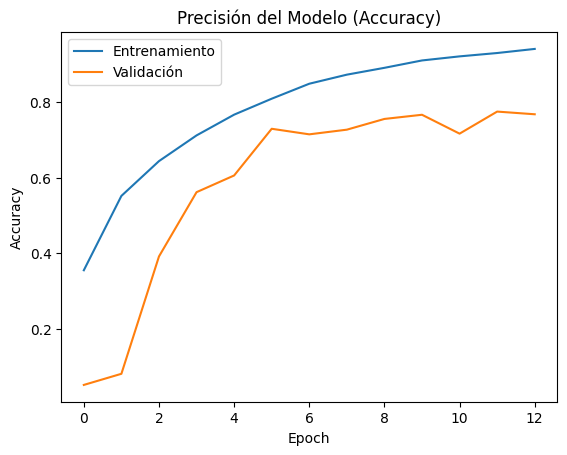

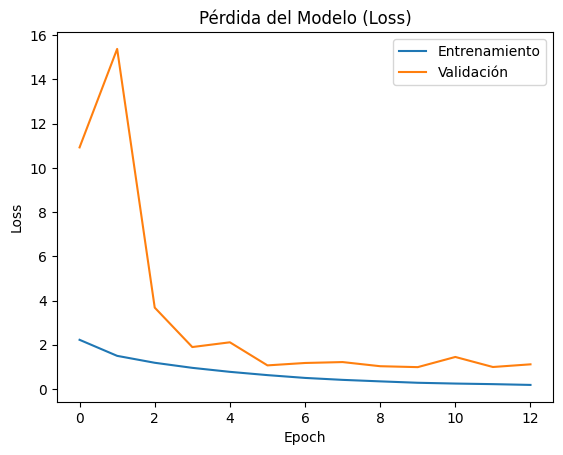

In [49]:
# Graficar la precisión (accuracy)
plot_acc(model_7_Relu_drop_bat_lr, title="Precisión del Modelo (Accuracy)")

# Graficar la pérdida (loss)
plot_loss(model_7_Relu_drop_bat_lr, title="Pérdida del Modelo (Loss)")

In [73]:
# Definir valores de accuracy y loss del modelo
acc_model_7 = model_7_Relu_drop_bat_lr.history['val_accuracy'][-1]
loss_model_7 = model_7_Relu_drop_bat_lr.history['val_loss'][-1]

# Agregar la fila con los resultados del modelo
myTable.add_row(["Modelo 7 (ReLU)", "{:.5f}".format(acc_model_7), "{:.5f}".format(loss_model_7)])

# Imprimir la tabla
print(myTable)

+-----------------+--------------+----------+
|   Experimento   | Val Accuracy | Val Loss |
+-----------------+--------------+----------+
| Modelo 1 (ReLU) |   0.69808    | 1.11499  |
| Modelo 2 (ReLU) |   0.71650    | 1.19031  |
| Modelo 3 (ReLU) |   0.12082    | 2.76263  |
| Modelo 4 (ReLU) |   0.63411    | 1.27055  |
| Modelo 5 (ReLU) |   0.72203    | 1.18113  |
| Modelo 6 (ReLU) |   0.75388    | 1.13026  |
| Modelo 7 (ReLU) |   0.76757    | 1.11579  |
+-----------------+--------------+----------+


#### Conclusión

In [ ]:
# Ha mejorado con respecto a los experimentos anteriores y evitando el overfitting gracias a los cambios realizados.
# Se va a aumentar la 'patience' para ver si se consigue mejores resultados.

### Experimento 8

In [53]:
# Definir y construir modelo
model = models.Sequential()

model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(Dropout(0.2))

model.add(layers.Conv2D(64,(2,2), activation='relu', padding='same', name='Convolutiva-2'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-2'))
model.add(Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', name='Hidden-Layer-1'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-2'))
model.add(Dropout(0.2))

model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))

model.summary()

# Compilar modelo
model.compile(
                      optimizer = Adam(learning_rate=0.0004),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
)
# Log del entrenamiento se guarda para analisis y visualizacion

early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

model_8_Relu_pat = model.fit(
                      x_train,
                      y_train,
                      epochs = 30,
                      batch_size= 64,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks = [early_stopping]
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Convolutiva-1 (Conv2D)               │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-1 (MaxPooling2D)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolutiva-2 (Conv2D)               │ (None, 32, 32, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-2 (MaxPooling2D)          │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,248,594 (16.21 MB)

 Trainable params: 4,247,826 (16.20 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.2629 - loss: 2.5865 - val_accuracy: 0.0500 - val_loss: 10.7285
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5308 - loss: 1.5741 - val_accuracy: 0.0956 - val_loss: 14.9137
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6399 - loss: 1.1987 - val_accuracy: 0.3930 - val_loss: 3.1157
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7101 - loss: 0.9644 - val_accuracy: 0.5193 - val_loss: 1.9708
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7677 - loss: 0.7742 - val_accuracy: 0.6625 - val_loss: 1.3961
Epoch 6/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8204 - loss: 0.5978 - val_accuracy: 0.6783 - val_loss: 1.4785
Epoch 7/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8380 - loss: 0.5088 - val_accuracy: 0.6017 - val_loss: 2.6047
Epoch 8/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8756 - loss: 0.3973 - val_

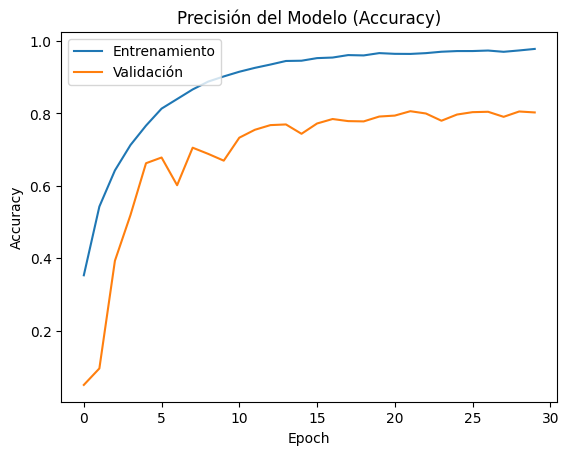

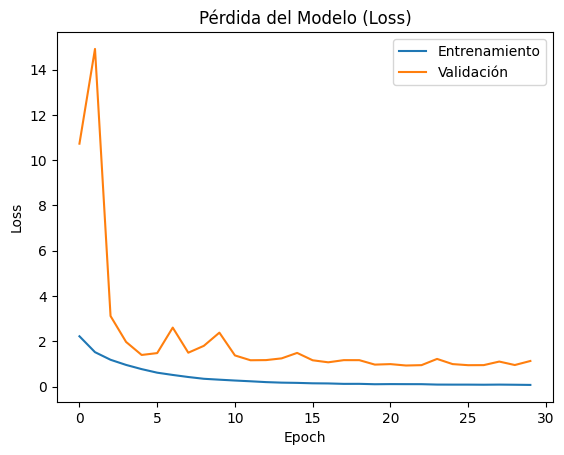

In [55]:
# Graficar la precisión (accuracy)
plot_acc(model_8_Relu_pat, title="Precisión del Modelo (Accuracy)")

# Graficar la pérdida (loss)
plot_loss(model_8_Relu_pat, title="Pérdida del Modelo (Loss)")

In [74]:
# Definir valores de accuracy y loss del modelo
acc_model_8 = model_8_Relu_pat.history['val_accuracy'][-1]
loss_model_8 = model_8_Relu_pat.history['val_loss'][-1]

# Agregar la fila con los resultados del modelo
myTable.add_row(["Modelo 8 (ReLU)", "{:.5f}".format(acc_model_8), "{:.5f}".format(loss_model_8)])

# Imprimir la tabla
print(myTable)

+-----------------+--------------+----------+
|   Experimento   | Val Accuracy | Val Loss |
+-----------------+--------------+----------+
| Modelo 1 (ReLU) |   0.69808    | 1.11499  |
| Modelo 2 (ReLU) |   0.71650    | 1.19031  |
| Modelo 3 (ReLU) |   0.12082    | 2.76263  |
| Modelo 4 (ReLU) |   0.63411    | 1.27055  |
| Modelo 5 (ReLU) |   0.72203    | 1.18113  |
| Modelo 6 (ReLU) |   0.75388    | 1.13026  |
| Modelo 7 (ReLU) |   0.76757    | 1.11579  |
| Modelo 8 (ReLU) |   0.80284    | 1.13007  |
+-----------------+--------------+----------+


#### Conclusión

In [ ]:
# Aumentando la patience se han mejorado los resultados pero aun asi son insuficientes.
# Para hacer que converga mas rapido se va a probar con un learning_rate adaptativo.

### Experimento 9

In [60]:
from keras.callbacks import ReduceLROnPlateau

# Definir y construir modelo
model = models.Sequential()

model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(Dropout(0.2))

model.add(layers.Conv2D(64,(2,2), activation='relu', padding='same', name='Convolutiva-2'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-2'))
model.add(Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', name='Hidden-Layer-1'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-2'))
model.add(Dropout(0.2))

model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))

model.summary()

# Compilar modelo
model.compile(
                      optimizer = Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
)
# Log del entrenamiento se guarda para analisis y visualizacion

# Callbacks para mejorar el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0001, verbose=1)

model_9_Relu_lr_adap = model.fit(
                      x_train,
                      y_train,
                      epochs = 30,
                      batch_size= 64,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Convolutiva-1 (Conv2D)               │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-1 (MaxPooling2D)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolutiva-2 (Conv2D)               │ (None, 32, 32, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-2 (MaxPooling2D)          │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,248,594 (16.21 MB)

 Trainable params: 4,247,826 (16.20 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.2679 - loss: 2.5710 - val_accuracy: 0.1208 - val_loss: 12.2926 - learning_rate: 0.0010
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5409 - loss: 1.5053 - val_accuracy: 0.1200 - val_loss: 19.9171 - learning_rate: 0.0010
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6575 - loss: 1.1357 - val_accuracy: 0.4864 - val_loss: 3.2690 - learning_rate: 0.0010
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7498 - loss: 0.8255 - val_accuracy: 0.6402 - val_loss: 1.8464 - learning_rate: 0.0010
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8082 - loss: 0.6231 - val_accuracy: 0.7449 - val_loss: 0.9261 - learning_rate: 0.0010
Epoch 6/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8358 - loss: 0.5260 - val_accuracy: 0.7434 - val_loss: 0.9974 - learning_rate: 0.0010
Epoch 7/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8811 - loss

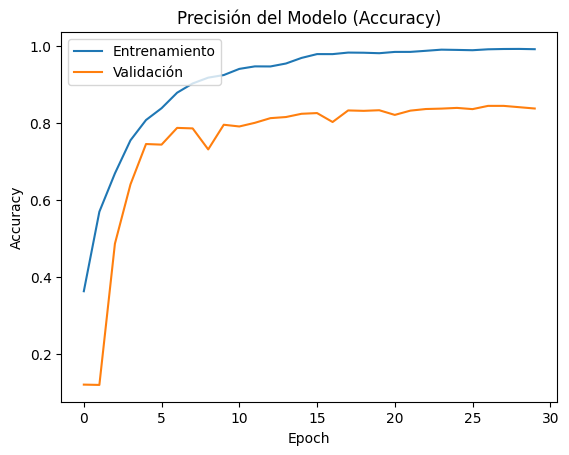

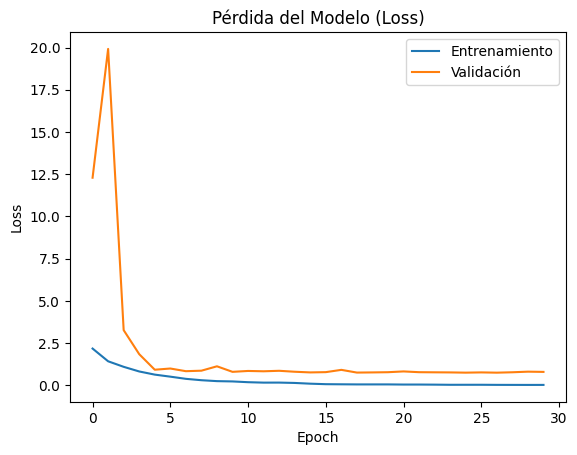

In [61]:
# Graficar la precisión (accuracy)
plot_acc(model_9_Relu_lr_adap, title="Precisión del Modelo (Accuracy)")

# Graficar la pérdida (loss)
plot_loss(model_9_Relu_lr_adap, title="Pérdida del Modelo (Loss)")

In [75]:
# Definir valores de accuracy y loss del modelo
acc_model_9 = model_9_Relu_lr_adap.history['val_accuracy'][-1]
loss_model_9 = model_9_Relu_lr_adap.history['val_loss'][-1]

# Agregar la fila con los resultados del modelo
myTable.add_row(["Modelo 9 (ReLU)", "{:.5f}".format(acc_model_9), "{:.5f}".format(loss_model_9)])

# Imprimir la tabla
print(myTable)

+-----------------+--------------+----------+
|   Experimento   | Val Accuracy | Val Loss |
+-----------------+--------------+----------+
| Modelo 1 (ReLU) |   0.69808    | 1.11499  |
| Modelo 2 (ReLU) |   0.71650    | 1.19031  |
| Modelo 3 (ReLU) |   0.12082    | 2.76263  |
| Modelo 4 (ReLU) |   0.63411    | 1.27055  |
| Modelo 5 (ReLU) |   0.72203    | 1.18113  |
| Modelo 6 (ReLU) |   0.75388    | 1.13026  |
| Modelo 7 (ReLU) |   0.76757    | 1.11579  |
| Modelo 8 (ReLU) |   0.80284    | 1.13007  |
| Modelo 9 (ReLU) |   0.83706    | 0.79739  |
+-----------------+--------------+----------+


#### Conclusión

In [63]:
# Hay que cambiar varios parametros para poder mejorar los resultados, ya que no han mejorado muy significativamente con respecto de los anteriores
# Para mejorar resultados se van tomar las siguientes medidas:
# reducir el batch_size de 64 a 32
# mas filtros en la CONV 2 (128)
# añadir una nueva capa convolutiva (CONV 3)
# mayor dropout general (0.3) y en la capa densa (0.6)
# aumentar las epochs a 50 y reducir la patience a 6

### Experimento 10

In [64]:
from keras.callbacks import ReduceLROnPlateau

# Definir y construir modelo
model = models.Sequential()

# CONV 1
model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same', name='Convolutiva-1'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-1'))
model.add(Dropout(0.3))

# CONV 2
model.add(layers.Conv2D(128,(2,2), activation='relu', padding='same', name='Convolutiva-2'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-2'))
model.add(Dropout(0.3))

# CONV 3
model.add(layers.Conv2D(256,(2,2), activation='relu', padding='same', name='Convolutiva-3'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), name='MaxPooling-3'))
model.add(Dropout(0.3))

# Capa densa
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', name='Hidden-Layer-1'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(layers.Dense(128, activation='relu', name='Hidden-Layer-2'))
model.add(Dropout(0.2))

# Capa de salida
model.add(layers.Dense(18, activation='softmax', name='Output-Layer'))

model.summary()

# Compilar modelo
model.compile(
                      optimizer = Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
)
# Log del entrenamiento se guarda para analisis y visualizacion

# Callbacks para mejorar el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0001, verbose=1)

model_10_Relu_capa = model.fit(
                      x_train,
                      y_train,
                      epochs = 50,
                      batch_size= 32,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Convolutiva-1 (Conv2D)               │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-1 (MaxPooling2D)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolutiva-2 (Conv2D)               │ (None, 32, 32, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-2 (MaxPooling2D)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolutiva-3 (Conv2D)               │ (None, 16, 16, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling-3 (MaxPooling2D)          │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 4,397,650 (16.78 MB)

 Trainable params: 4,396,242 (16.77 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.2266 - loss: 2.7294 - val_accuracy: 0.3159 - val_loss: 2.2615 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4901 - loss: 1.6801 - val_accuracy: 0.5341 - val_loss: 1.5830 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6267 - loss: 1.2214 - val_accuracy: 0.6994 - val_loss: 1.0002 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6931 - loss: 1.0063 - val_accuracy: 0.6886 - val_loss: 2.0293 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7450 - loss: 0.8301 - val_accuracy: 0.7270 - val_loss: 1.0153 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7804 - loss: 0.7185 - val_accuracy: 0.7670 - val_loss: 0.9312 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8013 - loss:

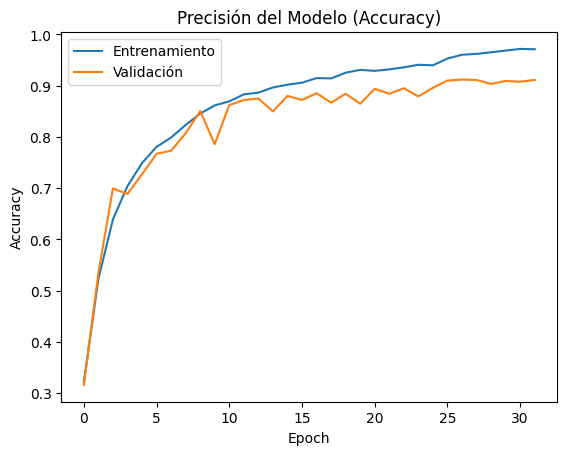

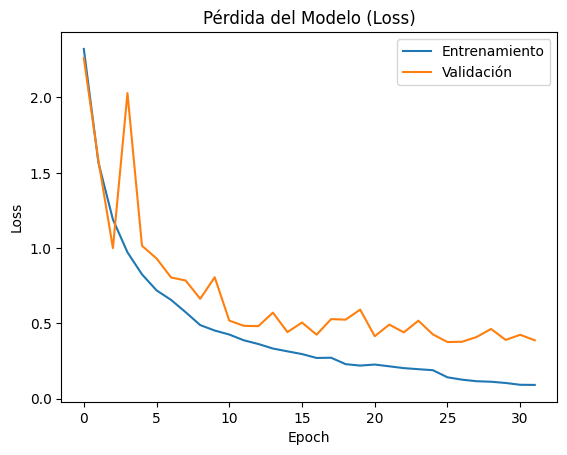

In [65]:
# Graficar la precisión (accuracy)
plot_acc(model_10_Relu_capa, title="Precisión del Modelo (Accuracy)")

# Graficar la pérdida (loss)
plot_loss(model_10_Relu_capa, title="Pérdida del Modelo (Loss)")

In [76]:
# Definir valores de accuracy y loss del modelo
acc_model_10 = model_10_Relu_capa.history['val_accuracy'][-1]
loss_model_10 = model_10_Relu_capa.history['val_loss'][-1]

# Agregar la fila con los resultados del modelo
myTable.add_row(["Modelo 10 (ReLU)", "{:.5f}".format(acc_model_10), "{:.5f}".format(loss_model_10)])

# Imprimir la tabla
print(myTable)

+------------------+--------------+----------+
|   Experimento    | Val Accuracy | Val Loss |
+------------------+--------------+----------+
| Modelo 1 (ReLU)  |   0.69808    | 1.11499  |
| Modelo 2 (ReLU)  |   0.71650    | 1.19031  |
| Modelo 3 (ReLU)  |   0.12082    | 2.76263  |
| Modelo 4 (ReLU)  |   0.63411    | 1.27055  |
| Modelo 5 (ReLU)  |   0.72203    | 1.18113  |
| Modelo 6 (ReLU)  |   0.75388    | 1.13026  |
| Modelo 7 (ReLU)  |   0.76757    | 1.11579  |
| Modelo 8 (ReLU)  |   0.80284    | 1.13007  |
| Modelo 9 (ReLU)  |   0.83706    | 0.79739  |
| Modelo 10 (ReLU) |   0.91129    | 0.38806  |
+------------------+--------------+----------+


#### Conclusión

In [ ]:
# Se ha conseguido el objetivo tras 10 experimentos (91% de Val Accuracy)

##Análisis de los errores de la red.

In [79]:
import numpy as np
from random import sample
from collections import Counter

# Seleccionar 100 imágenes aleatorias del conjunto de test
indices_aleatorios = sample(range(len(x_test)), k=100)

# Obtener predicciones para estas 100 imágenes
y_pred_100 = np.argmax(model.predict(x_test[indices_aleatorios]), axis=1)
y_real_100 = y_test[indices_aleatorios]

# Comparar predicciones con etiquetas reales
errores = []
for real, pred in zip(y_real_100, y_pred_100):
    if real != pred:
        errores.append(nombre_personajes[real])  # Guardamos el personaje real que fue mal clasificado

# Contar cuántas veces cada personaje fue mal clasificado
conteo_errores = Counter(errores)

# Mostrar los personajes más problemáticos
print("Personajes con más errores en la predicción:")
for personaje, cantidad in conteo_errores.most_common():
    print(f"{personaje}: {cantidad} errores")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Personajes con más errores en la predicción:
abraham_grampa_simpson: 2 errores
bart_simpson: 1 errores


- El personaje mas problematico de predecir es abraham_grampa_simpson con 2 errores.

### Matriz de confusion

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


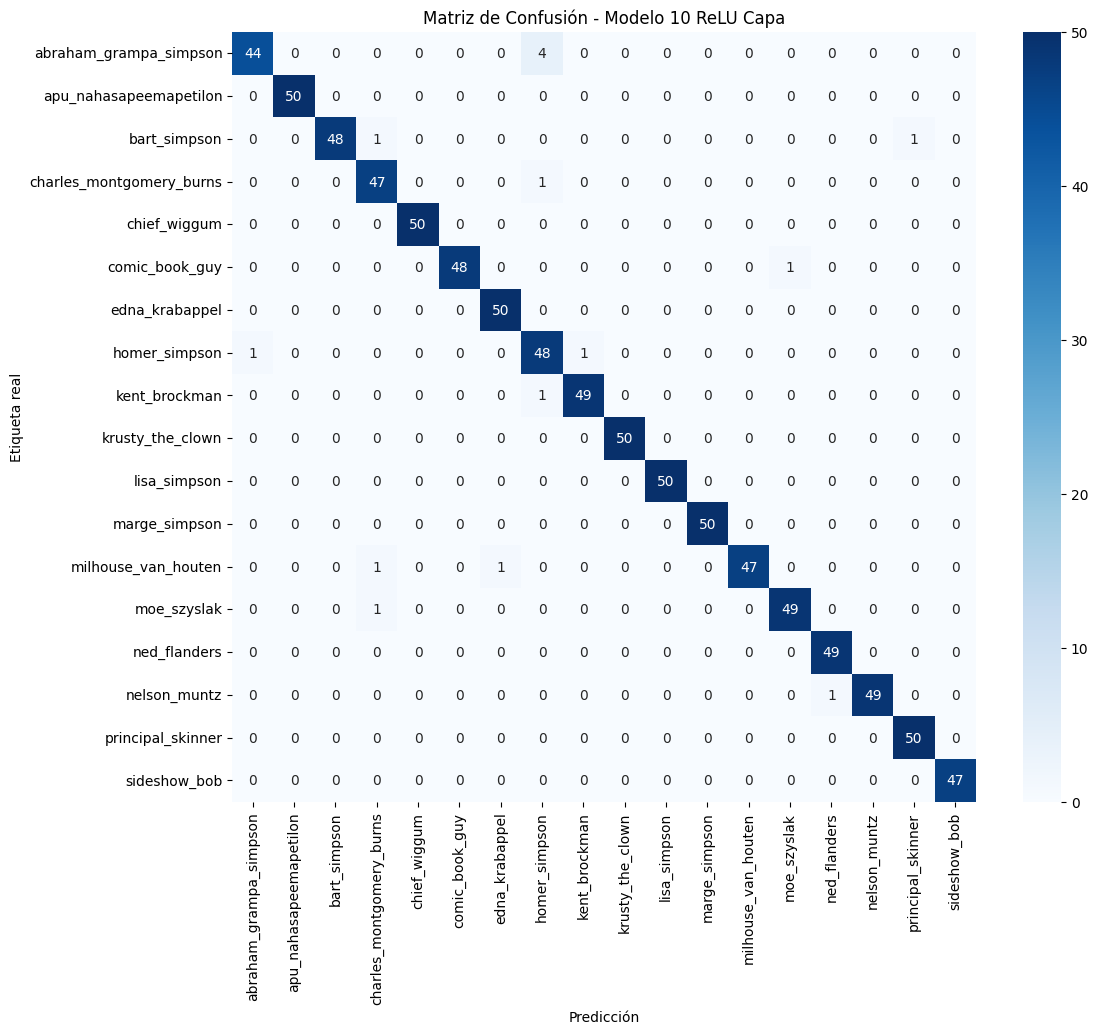

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener predicciones para todo el conjunto de test
y_pred_total = np.argmax(model.predict(x_test), axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred_total)

# Visualizar con heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=nombre_personajes, yticklabels=nombre_personajes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - Modelo 10 ReLU Capa")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# La mayoria de predicciones son acertadas.
# El error que mas destaca / se repite es que de 50 imágenes de 'abraham_grampa_simpson', 44 fueron clasificadas correctamente y 4 fueron clasificadas como 'homer_simpson';
# lo que indica que el modelo tiende ligeramente a confundirlos, podria ser debido a que como son padre e hijo, el diseño y los rasgos faciales sean parecidos.